Read 1000 cities from cities.txt


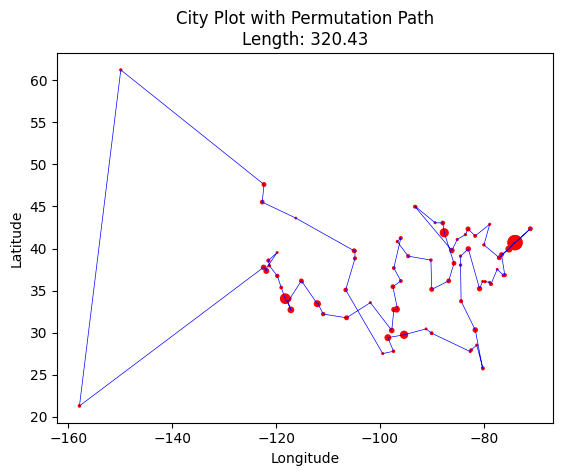

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
def read_cities(filename):
    with open(filename, "r") as f:
        lines = f.readlines()
    cities = []
    for line in lines:
        name, lat, lon, pop = line.split()
        cities.append((name, float(lat), float(lon), int(pop)))
    print(f"Read {len(cities)} cities from {filename}")
    return cities

def remove_outliers(cities):
    lats = [x[1] for x in cities]
    lons = [x[2] for x in cities]
    lat_mean = np.mean(lats)
    lat_std = np.std(lats)
    lon_mean = np.mean(lons)
    lon_std = np.std(lons)
    cities = list(filter(lambda x: abs(x[1] - lat_mean) < 3 * lat_std and abs(x[2] - lon_mean) < 3 * lon_std, cities))
    return cities

def map_range(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) // (in_max - in_min) + out_min

def plot_cities(cities):
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    plt.scatter(lons, lats, s=norm_pops, c="red")  # Using scatter for variable markersize
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("City Plot")
    plt.show()
    
# Example cities data
cities = [
    ("City1", 0, 0, 1000),
    ("City2", 1, 1, 2000),
    ("City3", 2, 0, 1500),
    ("City4", 0, 2, 3000),
]
cities = read_cities("cities.txt")[:100]

# Function to calculate the Euclidean distance between two points
def distance(lat1, lon1, lat2, lon2):
    return np.sqrt((lat1 - lat2)**2 + (lon1 - lon2)**2)

# Function to map population range for plotting
def map_range(value, left_min, left_max, right_min, right_max):
    left_span = left_max - left_min
    right_span = right_max - right_min
    value_scaled = float(value - left_min) / float(left_span)
    return right_min + (value_scaled * right_span)

# Function to get path length
def path_length(cities, p, full=False):
    length = 0
    for i in range(len(p) - 1):
        c1 = cities[p[i]]
        c2 = cities[p[i + 1]]
        length += distance(c1[1], c1[2], c2[1], c2[2])
    if full:
        length += distance(cities[p[0]][1], cities[p[0]][2], cities[p[-1]][1], cities[p[-1]][2])
    return length

# Function to plot cities permutation
def plot_cities_permutation(cities, p):
    length = path_length(cities, p, full=True)
    permuted_cities = [cities[i] for i in p]
    lats, lons, pops = zip(*[(x[1], x[2], x[3]) for x in permuted_cities])
    min_pop, max_pop = min(pops), max(pops)
    norm_pops = [map_range(pop, min_pop, max_pop, 1, 100) for pop in pops]
    
    plt.scatter(lons, lats, s=norm_pops, c="red")
    plt.plot(lons, lats, linestyle='-', color='blue', linewidth=0.5)
    plt.plot([lons[-1], lons[0]], [lats[-1], lats[0]], linestyle='-', color='blue', linewidth=0.5)  # Closing the loop
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"City Plot with Permutation Path\nLength: {length:.2f}")
    plt.show()

# Christofides algorithm implementation
def christofides(cities):
    # Create a complete graph with distances as edge weights
    G = nx.Graph()
    for i, c1 in enumerate(cities):
        for j, c2 in enumerate(cities):
            if i != j:
                G.add_edge(i, j, weight=distance(c1[1], c1[2], c2[1], c2[2]))

    # Step 1: Find the Minimum Spanning Tree (MST)
    MST = nx.minimum_spanning_tree(G)

    # Step 2: Find the vertices with odd degree in the MST
    odd_degree_nodes = [v for v, d in MST.degree() if d % 2 == 1]

    # Step 3: Find the minimum weight perfect matching for the odd degree vertices
    odd_subgraph = G.subgraph(odd_degree_nodes)
    matching = nx.algorithms.matching.min_weight_matching(odd_subgraph)

    # Combine the matching and the MST to form a multigraph
    multigraph = nx.MultiGraph()
    multigraph.add_edges_from(MST.edges)
    multigraph.add_edges_from(matching)

    # Step 4: Form an Eulerian circuit from the multigraph
    eulerian_circuit = list(nx.eulerian_circuit(multigraph))

    # Step 5: Create a Hamiltonian circuit by shortcutting repeated vertices
    visited = set()
    path = []
    for u, v in eulerian_circuit:
        if u not in visited:
            visited.add(u)
            path.append(u)
    path.append(path[0])  # Closing the loop

    return path

# Example usage
p = christofides(cities)
plot_cities_permutation(cities, p)
